<a href="https://colab.research.google.com/github/dcolinmorgan/human-pose-estimation-opencv/blob/master/demo_ControlNet_Inpaint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/mikonvergence/ControlNetInpaint/blob/main/ControlNet-with-Inpaint-Demo-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install diffusers==0.14.0 xformers transformers scipy ftfy accelerate controlnet_aux

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_nvjitlink_cu12-12.6.20-py3-none-manyl

In [2]:
! git clone https://github.com/mikonvergence/ControlNetInpaint
import sys
sys.path.append('./ControlNetInpaint/')

Cloning into 'ControlNetInpaint'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 88 (delta 27), reused 19 (delta 18), pack-reused 54
Receiving objects: 100% (88/88), 15.06 MiB | 41.44 MiB/s, done.
Resolving deltas: 100% (34/34), done.


# Inpainting with ControlNet
This notebook contains examples of using a new `StableDiffusionControlNetInpaintPipeline`.

The main two parameters you can play with are the strength of text guidance and image guidance:
* Text guidance (`guidance_scale`) is set to `7.5` by default, and usually this value works quite well.
* Image guidance (`controlnet_conditioning_scale`) is set to `0.4` by default. This value is a good starting point, but can be lowered if there is a big misalignment between the text prompt and the control image (meaning that it is very hard to "imagine" an output image that both satisfies the text prompt and aligns with the control image).

The naming of these parameters is based on other pipelines `StableDiffusionInpaintPipeline` and `StableDiffusionControlNetPipeline` and the same convention has been preserved for consistency.

In [3]:
!pip install "jax[cuda12_local]==0.4.23" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# !pip install diffusers==0.11.1
# !pip install transformers scipy ftfy accelerate

from diffusers import StableDiffusionInpaintPipeline, ControlNetModel, UniPCMultistepScheduler
from src.pipeline_stable_diffusion_controlnet_inpaint import *
from diffusers.utils import load_image

import cv2
from PIL import Image
import numpy as np
import torch
from matplotlib import pyplot as plt

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.8/131.8 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.4 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.26+cuda12.cudnn89
    Uninstalling jaxlib-0.4.26+cuda12.cudnn89:
      Successfully uninstalled jaxlib-0.4.26+cuda12.cudnn89
  Attempting uninstall: jax
    Found existing installation: jax 0.4.26
    Uninstalling jax-0.4.26:
      Successfully uninstalled jax-0.4.26
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
orbax-checkpoint 0.5.23 requires jax>=0.4.26, but you have jax 0.4.23 which is incompatible.


/usr/local/lib/python3.10/dist-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/usr/local/lib/python3.10/dist-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


### Baseline: Stable Diffusion 1.5 Inpainting
The StableDiffusion1.5 Inpainting model is used as the core for ControlNet inpainting. For reference, you can also try to run the same results on this core model alone:

In [4]:
pipe_sd = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    revision="fp16",
    torch_dtype=torch.float16,
)
# speed up diffusion process with faster scheduler and memory optimization
pipe_sd.scheduler = UniPCMultistepScheduler.from_config(pipe_sd.scheduler.config)
# remove following line if xformers is not installed
pipe_sd.enable_xformers_memory_efficient_attention()

pipe_sd.to('cuda')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:99: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


model_index.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

text_encoder/model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.75k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/635 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/821 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/810 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/608M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/models/modeling_utils.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location

StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.14.0",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [7]:
# load control net and stable diffusion v1-5
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
 )

# speed up diffusion process with faster scheduler and memory optimization
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# remove following line if xformers is not installed
pipe.enable_xformers_memory_efficient_attention()

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

### OpenPose

In [47]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-openpose", torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
 )

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Remove if you do not have xformers installed
# see https://huggingface.co/docs/diffusers/v0.13.0/en/optimization/xformers#installing-xformers
# for installation instructions
pipe.enable_xformers_memory_efficient_attention()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/models/modeling_utils.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location

In [54]:
from controlnet_aux import OpenposeDetector

openpose = OpenposeDetector.from_pretrained('lllyasviel/ControlNet')

pose_real_image = load_image("https://github.com/dcolinmorgan/human-pose-estimation-opencv/blob/970495520d32842266f194b72864dcd29eed083b/Photo5623.jpg?raw=true")

pose_image = openpose(pose_real_image)
pose_real_image=pose_real_image.resize(pose_image.size)



In [63]:
pose_mask=np.zeros_like(np.array(pose_image))
pose_mask[250:1000,:,:]=255
pose_mask=Image.fromarray(pose_mask)

  0%|          | 0/20 [00:00<?, ?it/s]

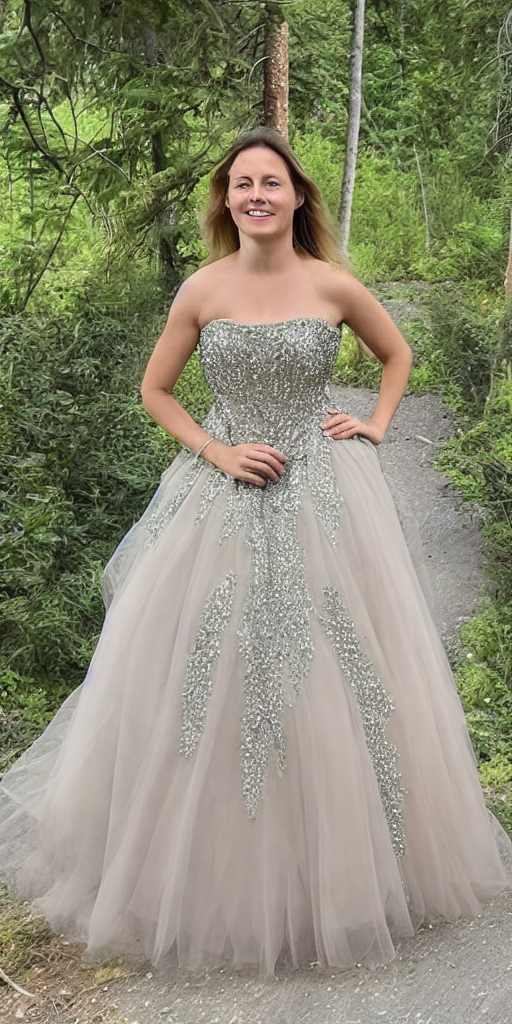

In [64]:
pipe.to('cuda')

# generate image
generator = torch.manual_seed(np.random.randint(100000,size=1))
new_image = pipe(
    "woman in elegrant, full length ball dress and glass slippers",
    num_inference_steps=20,
    generator=generator,
    image=pose_real_image,
    control_image=pose_image,
    mask_image=pose_mask
).images[0]

new_image

(-0.5, 511.5, 1023.5, -0.5)

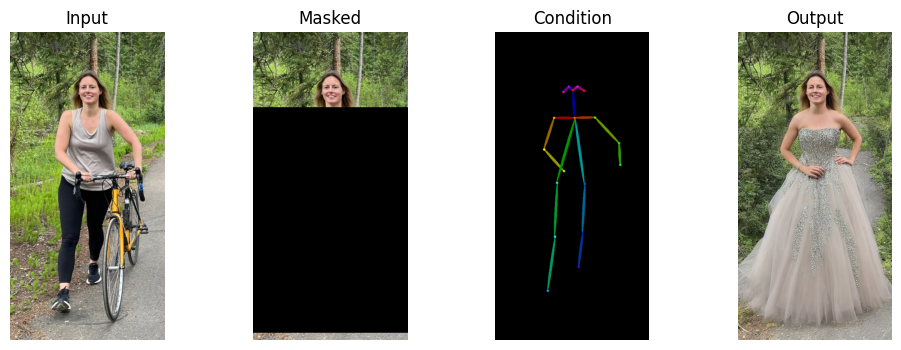

In [66]:
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(pose_real_image)
plt.axis('off')
plt.title('Input')
plt.subplot(1,4,2)
plt.imshow((255-np.array(pose_real_image))*(255-np.array(pose_mask)))
plt.axis('off')
plt.title('Masked')
plt.subplot(1,4,3)
plt.imshow(pose_image)
plt.axis('off')
plt.title('Condition')
plt.subplot(1,4,4)
plt.imshow(new_image)
plt.title('Output')
plt.axis('off')